# Evaluation


In [12]:
import h5py
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from config import SpectrogramClassificationConfig, LatentSpectrogramConfig
from tqdne.metric import AmplitudeSpectralDensity, frechet_distance
from tqdne.dataset import Dataset
from tqdne.plot import BinPlot, MovingAverageEnvelopeGrid, AmplitudeSpectralDensityGrid

## Setup

In [ ]:
test = h5py.File("workdir/evaluation/Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4-split_test-rank_0.h5", "r")
train = h5py.File("workdir/evaluation/Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4-split_train-rank_0.h5", "r")
validation = h5py.File("workdir/evaluation/Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4-split_validation-rank_0.h5", "r")

In [14]:
config = SpectrogramClassificationConfig("workdir")
mag_bins = config.mag_bins
dist_bins = config.dist_bins
evaluation_dir =  "workdir/evaluation/"

# Matplotlib settings
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False
rcParams["font.size"] = 16

## Data distribution
Create the plot for the binning of the data and the heatmap for the number of samples in each bin.

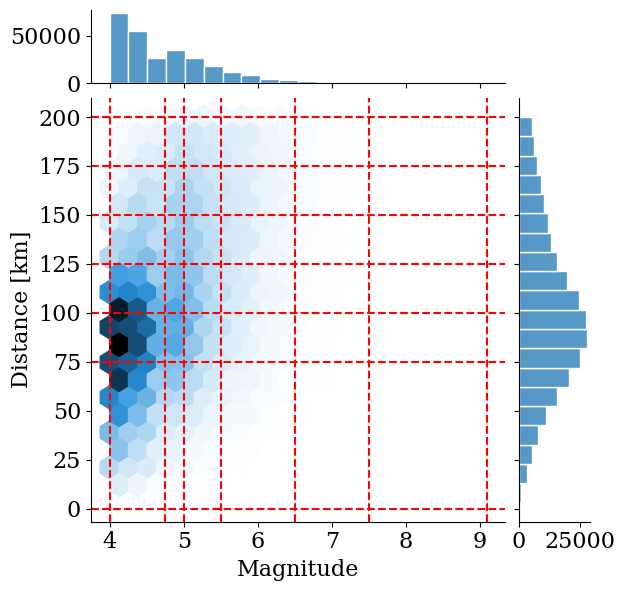

In [5]:
mag = np.concatenate([train.file["magnitude"][:], validation.file["magnitude"][:], test.file["magnitude"][:]])
dist = np.concatenate([train.file["hypocentral_distance"][:], validation.file["hypocentral_distance"][:], test.file["hypocentral_distance"][:]])
fig = sns.jointplot(
    x=mag,
    y=dist * 1000,
    kind="hex",
    marginal_ticks=True,
    joint_kws=dict(gridsize=20),
    marginal_kws=dict(bins=20, edgecolor="white"),
)
# plot.figure.set_size_inches([fig_width, fig_width])
plt.xlabel("Magnitude")
plt.ylabel("Distance [km]")

# draw bins
for x in mag_bins:
    plt.axvline(x, color="red", linestyle="--")
for y in dist_bins:
    plt.axhline(y, color="red", linestyle="--")

fig.savefig("workdir/figures/binning.pdf")

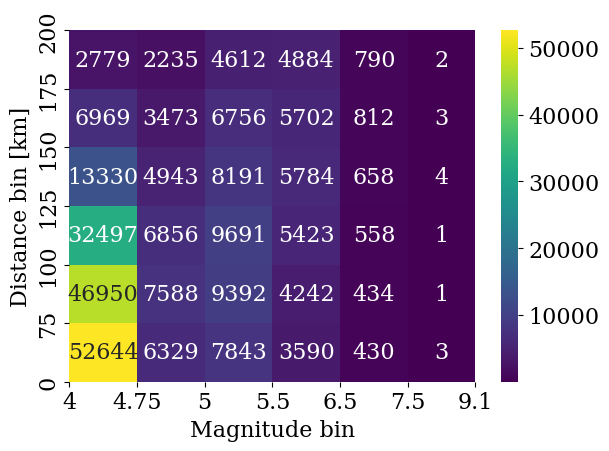

In [6]:
size_metric = lambda x, *args, **kwargs: len(x)
fig = BinPlot(metric=size_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt="d")(
    pred=mag, target=mag, mag=mag, dist=dist * 1000
)
fig.savefig("workdir/figures/class_distribution.pdf")

## Embedding Frechet Distance (FID)

In [ ]:
print(
    f"Train vs Generated (Test): {round( frechet_distance( test['predicted_classifier_embedding'][:],  np.concatenate([train['target_classifier_embedding'][:], validation['target_classifier_embedding'][:]]),  isotropic=True), 2 )}"
)
print(
    f"Train vs Test: {round(frechet_distance(np.concatenate([train['target_classifier_embedding'][:], validation['target_classifier_embedding'][:]]), test['target_classifier_embedding'][:], isotropic=True), 2)}"
)
print(
    f"Train vs Generated (Train): {round(frechet_distance(np.concatenate([train['target_classifier_embedding'][:], validation['target_classifier_embedding'][:]]), np.concatenate([train['predicted_classifier_embedding'][:], validation['predicted_classifier_embedding'][:]]), isotropic=True), 2)}"
)

Train vs Generated (Test): 11.380000114440918
Train vs Test: 6.21999979019165
Train vs Generated (Train): 10.890000343322754


In [13]:
from scipy import linalg

In [14]:
def frechet_distance(x: np.ndarray, y: np.ndarray, isotropic=False, eps=1e-6):
    """Compute the Frechet Distance between two sets of samples."""

    mu_x = np.nanmean(x, axis=0)
    mu_y = np.nanmean(y, axis=0)
    print(mu_x.shape)

    if isotropic:
        std_x = np.nanstd(x, axis=0)
        std_y = np.nanstd(y, axis=0)
        return np.sum((mu_x - mu_y) ** 2) + np.sum((std_x - std_y) ** 2)

    cov_x = np.cov(x, rowvar=False)
    cov_y = np.cov(y, rowvar=False)

    # # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov_x @ cov_y, disp=False)
    if not np.isfinite(covmean).all():
        print(
            f"fid calculation produces singular product; adding {eps} to diagonal of cov estimates"
        )
        offset = np.eye(cov_x.shape[0]) * eps
        covmean = linalg.sqrtm((cov_x + offset) @ (cov_y + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f"Imaginary component {np.max(np.abs(covmean.imag))}")
        covmean = covmean.real

    return np.sum((mu_x - mu_y) ** 2) + np.trace(cov_x) + np.trace(cov_y) - 2 * np.trace(covmean)

In [ ]:
class BinningPlot:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:                        
                        results[i].append(np.nan)
                else:
                    results[i].append(0)

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="viridis")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig

In [21]:
import scipy.linalg as linalg

(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
----
(1, 256)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
----
(1, 256)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)


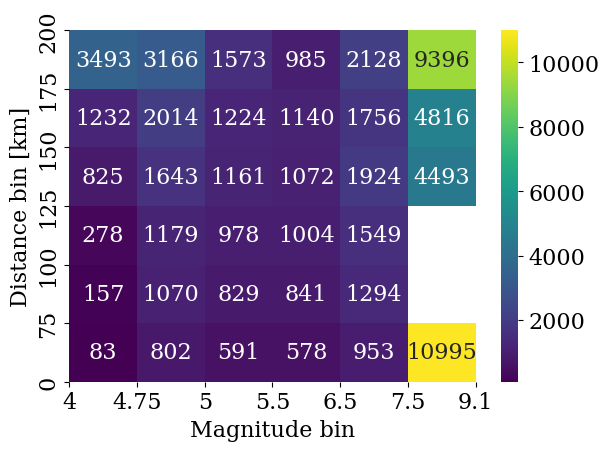

In [ ]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
fig = BinningPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f").plot(
    pred=np.concatenate([train["predicted_classifier_embedding"][:], validation["predicted_classifier_embedding"][:], test["predicted_classifier_embedding"][:]]),
    target=np.concatenate([train["target_classifier_embedding"][:], validation["target_classifier_embedding"][:], test["target_classifier_embedding"][:]]),
    mag=np.concatenate([train["magnitude"][:], validation["magnitude"][:], test["magnitude"][:]]),
    dist=np.concatenate([train["hypocentral_distance"][:], validation["hypocentral_distance"][:], test["hypocentral_distance"][:]]) * 1000,
)
fig.savefig("workdir/figures/embedding_fd_heatmap.pdf")

(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
----
(1, 256)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)


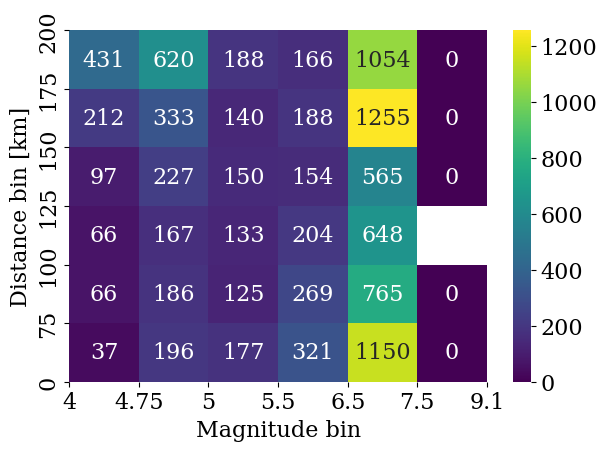

In [27]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
fig = BinningPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f").plot(
    pred=test["predicted_classifier_embedding"][:],
    target=test["target_classifier_embedding"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:] * 1000,
)
fig.savefig("workdir/figures/embedding_fd_heatmap-test.pdf")

## Classifier Accuracy

In [2]:
def get_label(mag, dist):
    return (np.digitize(dist, dist_bins) - 1) * (len(mag_bins) - 1) + np.digitize(mag, mag_bins) - 1


def accuracy(logits, labels):
    return (logits.argmax(axis=-1) == labels).mean() * 100

In [22]:
np.unique(get_label(train['magnitude'][:], train['hypocentral_distance'][:] * 1000), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35]),
 array([44715,  5437,  6676,  3073,   363,     3, 39896,  6455,  7989,
         3587,   367,     1, 27584,  5799,  8209,  4629,   464, 11299,
         4231,  6950,  4903,   559,     4,  5953,  2967,  5673,  4902,
          699,     3,  2374,  1925,  3944,  4123,   681,     2]))

In [25]:
len(train['magnitude'][:])

226439

In [ ]:
44715/len(train['magnitude'][:])

0.19747040041688932

In [41]:
print(
    f"Generated Test: {round(accuracy(test['predicted_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:] * 1000)), 2)} %"
)
print(
    f"Test: {round(accuracy(test['target_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:] * 1000)), 2)} %"
)

Generated Test: 69.13 %
Test: 72.71 %


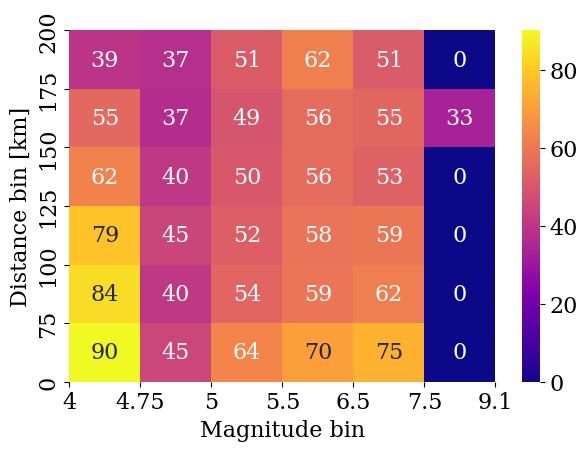

In [40]:
class BinningPlotAcc:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:
                        print(e)                        
                        print("----")
                        print(pred[mask].shape)    
                        results[i].append(np.nan)
                else:
                    results[i].append(0)

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="plasma")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig

fig = BinningPlotAcc(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=np.concatenate([train['predicted_classifier_pred'][:], validation['predicted_classifier_pred'][:], test['predicted_classifier_pred'][:]]),
    target=get_label(
        np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]), np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000
    ),  # missusing target for labels
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000,
)
fig.savefig("../figures/accuracy_heatmap.pdf")

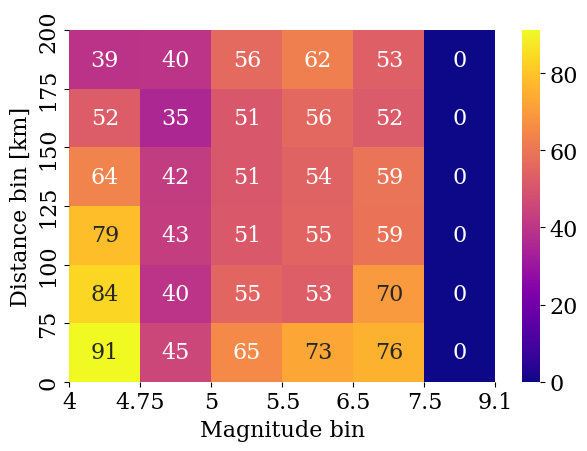

In [44]:

fig = BinningPlotAcc(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=test["predicted_classifier_pred"][:],
    target=get_label(test["magnitude"][:], test["hypocentral_distance"][:] * 1000),
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:] * 1000,
)
fig.savefig("workdir/figures/accuracy_heatmap-test.pdf")

## Amplitude Spectral Density

In [9]:
train['predicted_waveform'].shape[0]

226439

In [ ]:
266399

In [ ]:
print(
    f"Channel 0: Generated vs Test: {round(AmplitudeSpectralDensity(100, 0)(np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:]]), test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Train vs Test: {round(AmplitudeSpectralDensity(100, 0)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


print(
    f"Channel 1: Generated vs Test: {round(AmplitudeSpectralDensity(100, 1)(np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:]]), test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Train vs Test: {round(AmplitudeSpectralDensity(100, 1)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


print(
    f"Channel 2: Generated vs Test: {round(AmplitudeSpectralDensity(100, 2)(np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:]]), test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Train vs Test: {round(AmplitudeSpectralDensity(100, 2)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


Channel 0: Generated vs Test: 40.119998931884766
Channel 0: Train vs Test: 0.30000001192092896
Channel 1: Generated vs Test: 25.93000030517578
Channel 1: Train vs Test: 0.27000001072883606
Channel 2: Generated vs Test: 34.279998779296875
Channel 2: Train vs Test: 0.1599999964237213


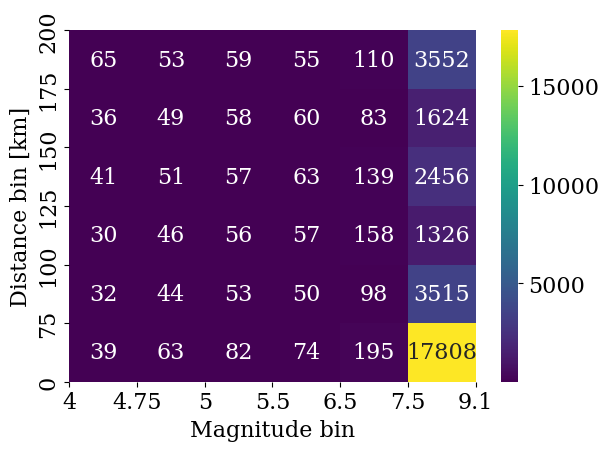

In [ ]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 0, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000,
)
fig.savefig("workdir/figures/asd_heatmap_0.pdf")

In [37]:
class BinPlotMultiMetric:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metrics = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])
                ret = np.array([metric(pred[mask], target[mask]) for metric in self.metrics])
                results[i].append(np.mean(ret))

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="viridis")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig

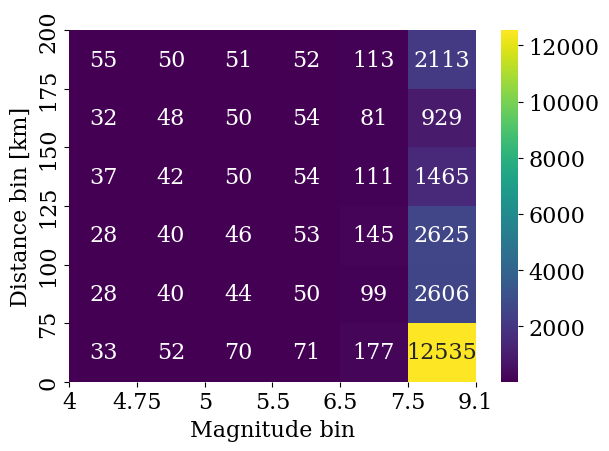

In [42]:
fig = BinPlotMultiMetric(metric=[AmplitudeSpectralDensity(100, 0, isotropic=True), AmplitudeSpectralDensity(100, 1, isotropic=True), AmplitudeSpectralDensity(100, 2, isotropic=True)], mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000,
)
fig.savefig("workdir/figures/asd_heatmap.pdf")

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/metric.py:16: RuntimeWarning: Mean of empty slice.
  mu_x = x.mean(0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/metric.py:17: RuntimeWarning: Mean of empty slice.
  mu_y = y.mean(0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workd

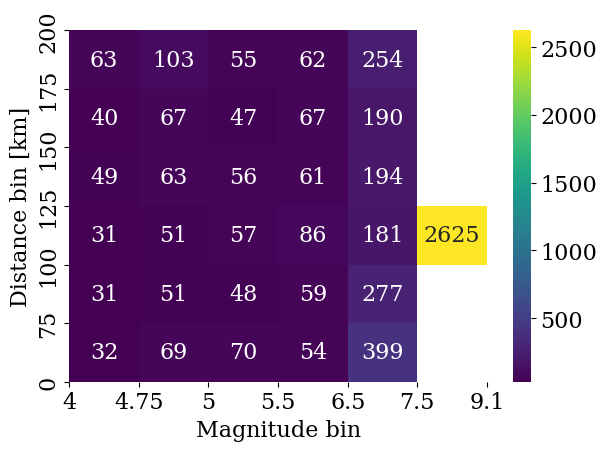

In [38]:
fig = BinPlotMultiMetric(metric=[AmplitudeSpectralDensity(100, 0, isotropic=True), AmplitudeSpectralDensity(100, 1, isotropic=True), AmplitudeSpectralDensity(100, 2, isotropic=True)], mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=test['predicted_waveform'][:],
    target=test['target_waveform'][:],
    mag=test['magnitude'][:],
    dist=test['hypocentral_distance'][:] * 1000,
)
fig.savefig("workdir/figures/asd_heatmap-test.pdf")

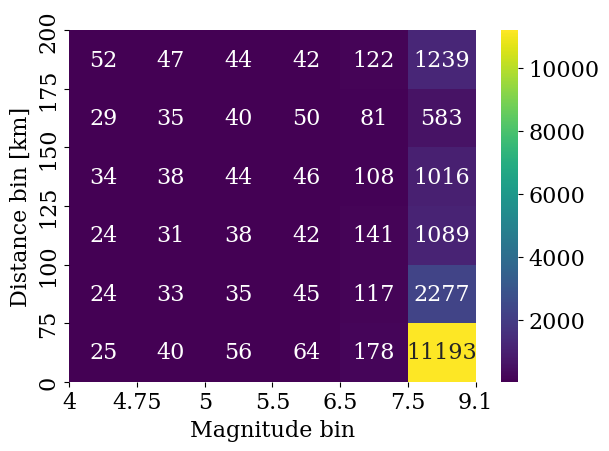

In [ ]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000,
)
fig.savefig("workdir/figures/asd_heatmap_1.pdf")

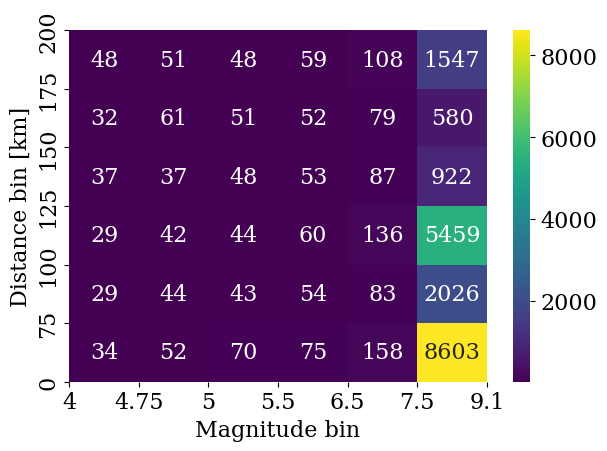

In [ ]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 2, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) * 1000,
)
fig.savefig("workdir/figures/asd_heatmap_2.pdf")

## Grid plot

In [5]:
distance_bins = config.dist_bins
magnitude_bins = config.mag_bins
channel = 2

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

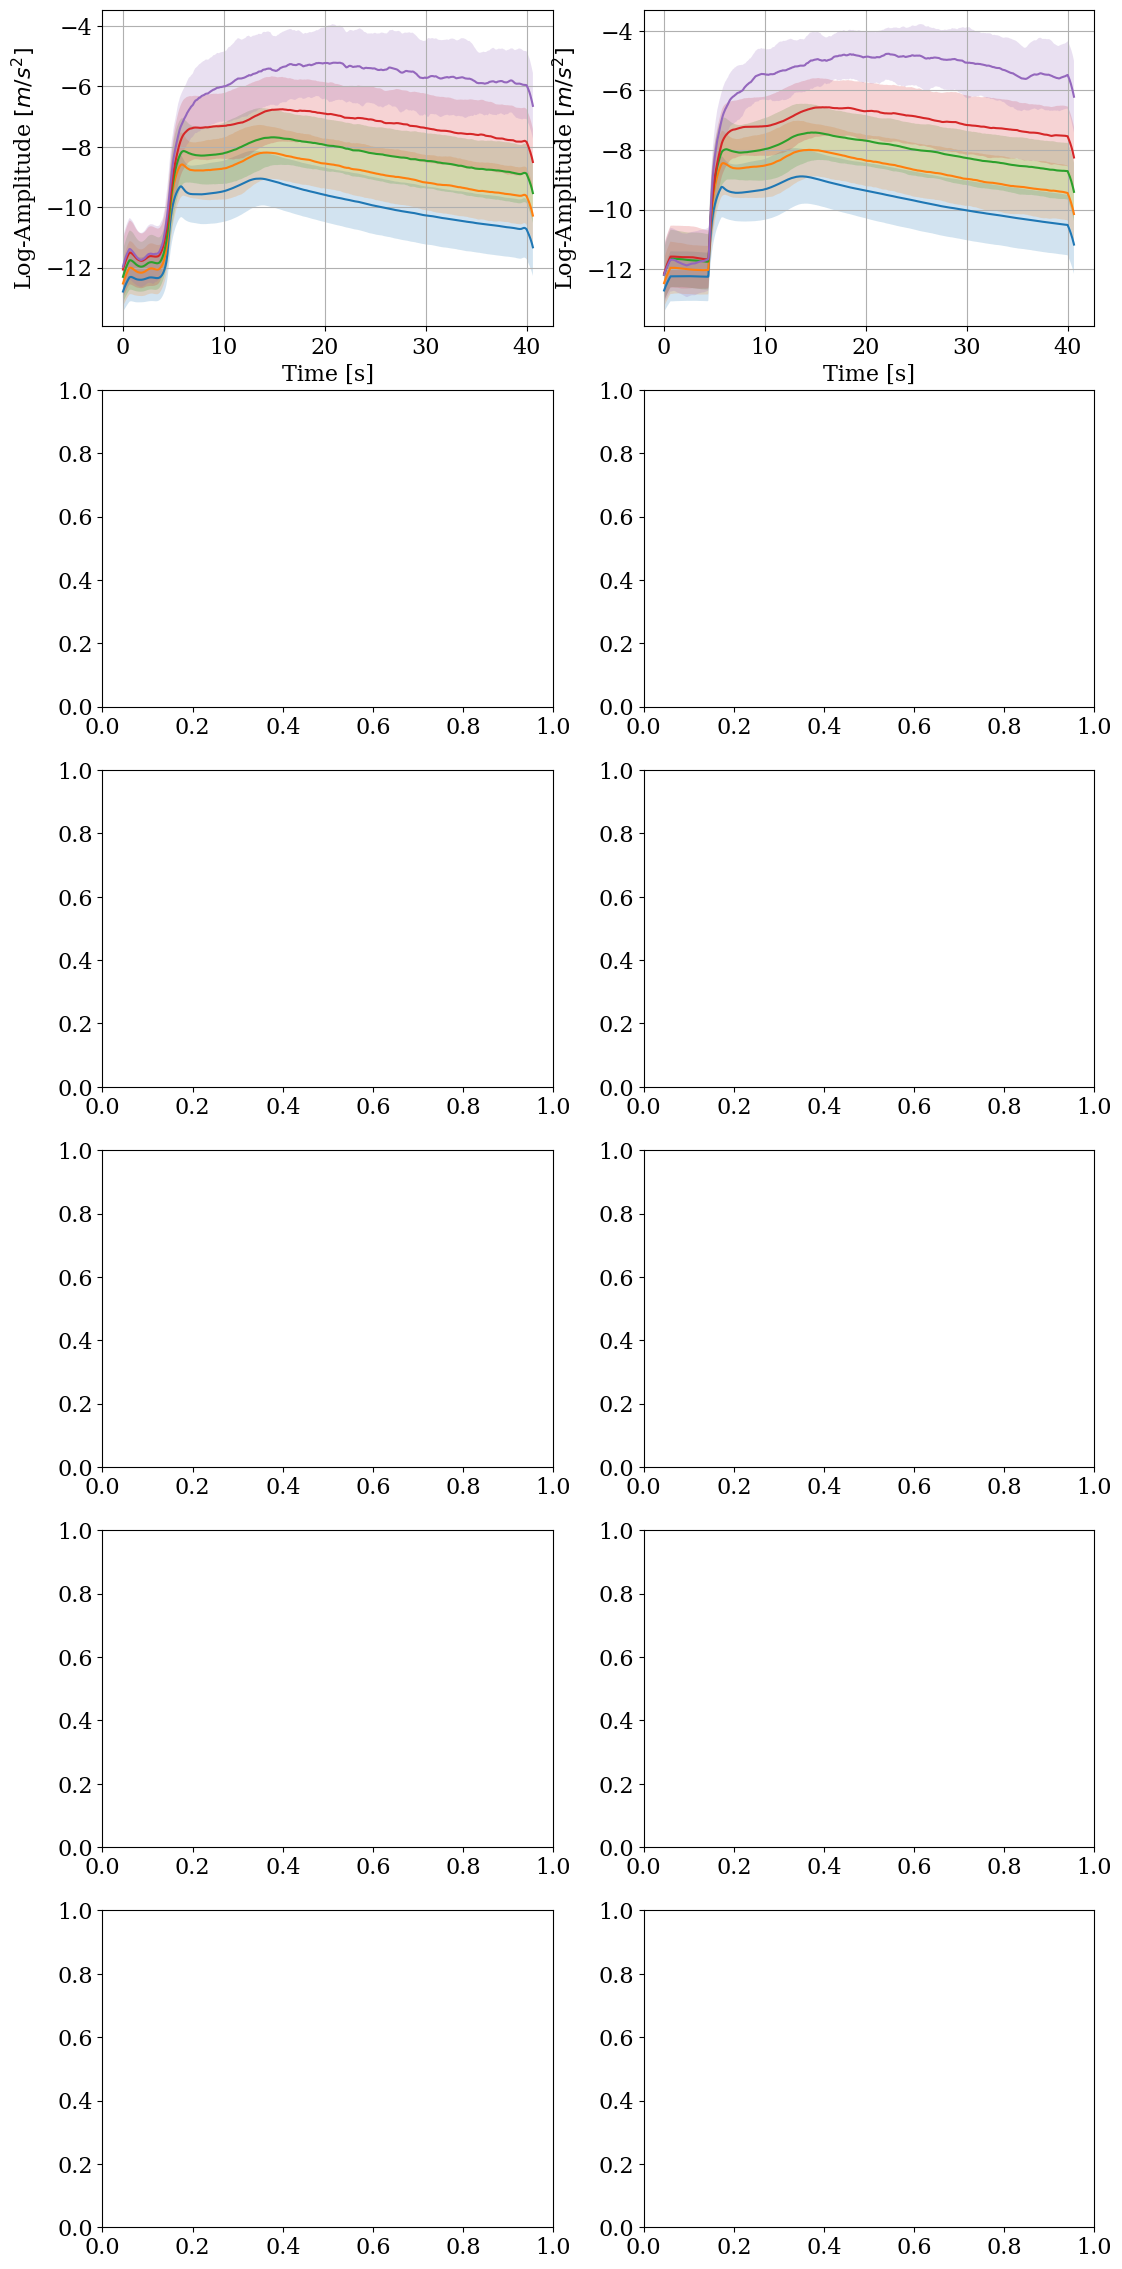

In [ ]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=channel, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:] * 1000,
)
fig.savefig(f"workdir/figures/moving_average_envelope_grid_{channel}.pdf", bbox_inches="tight")

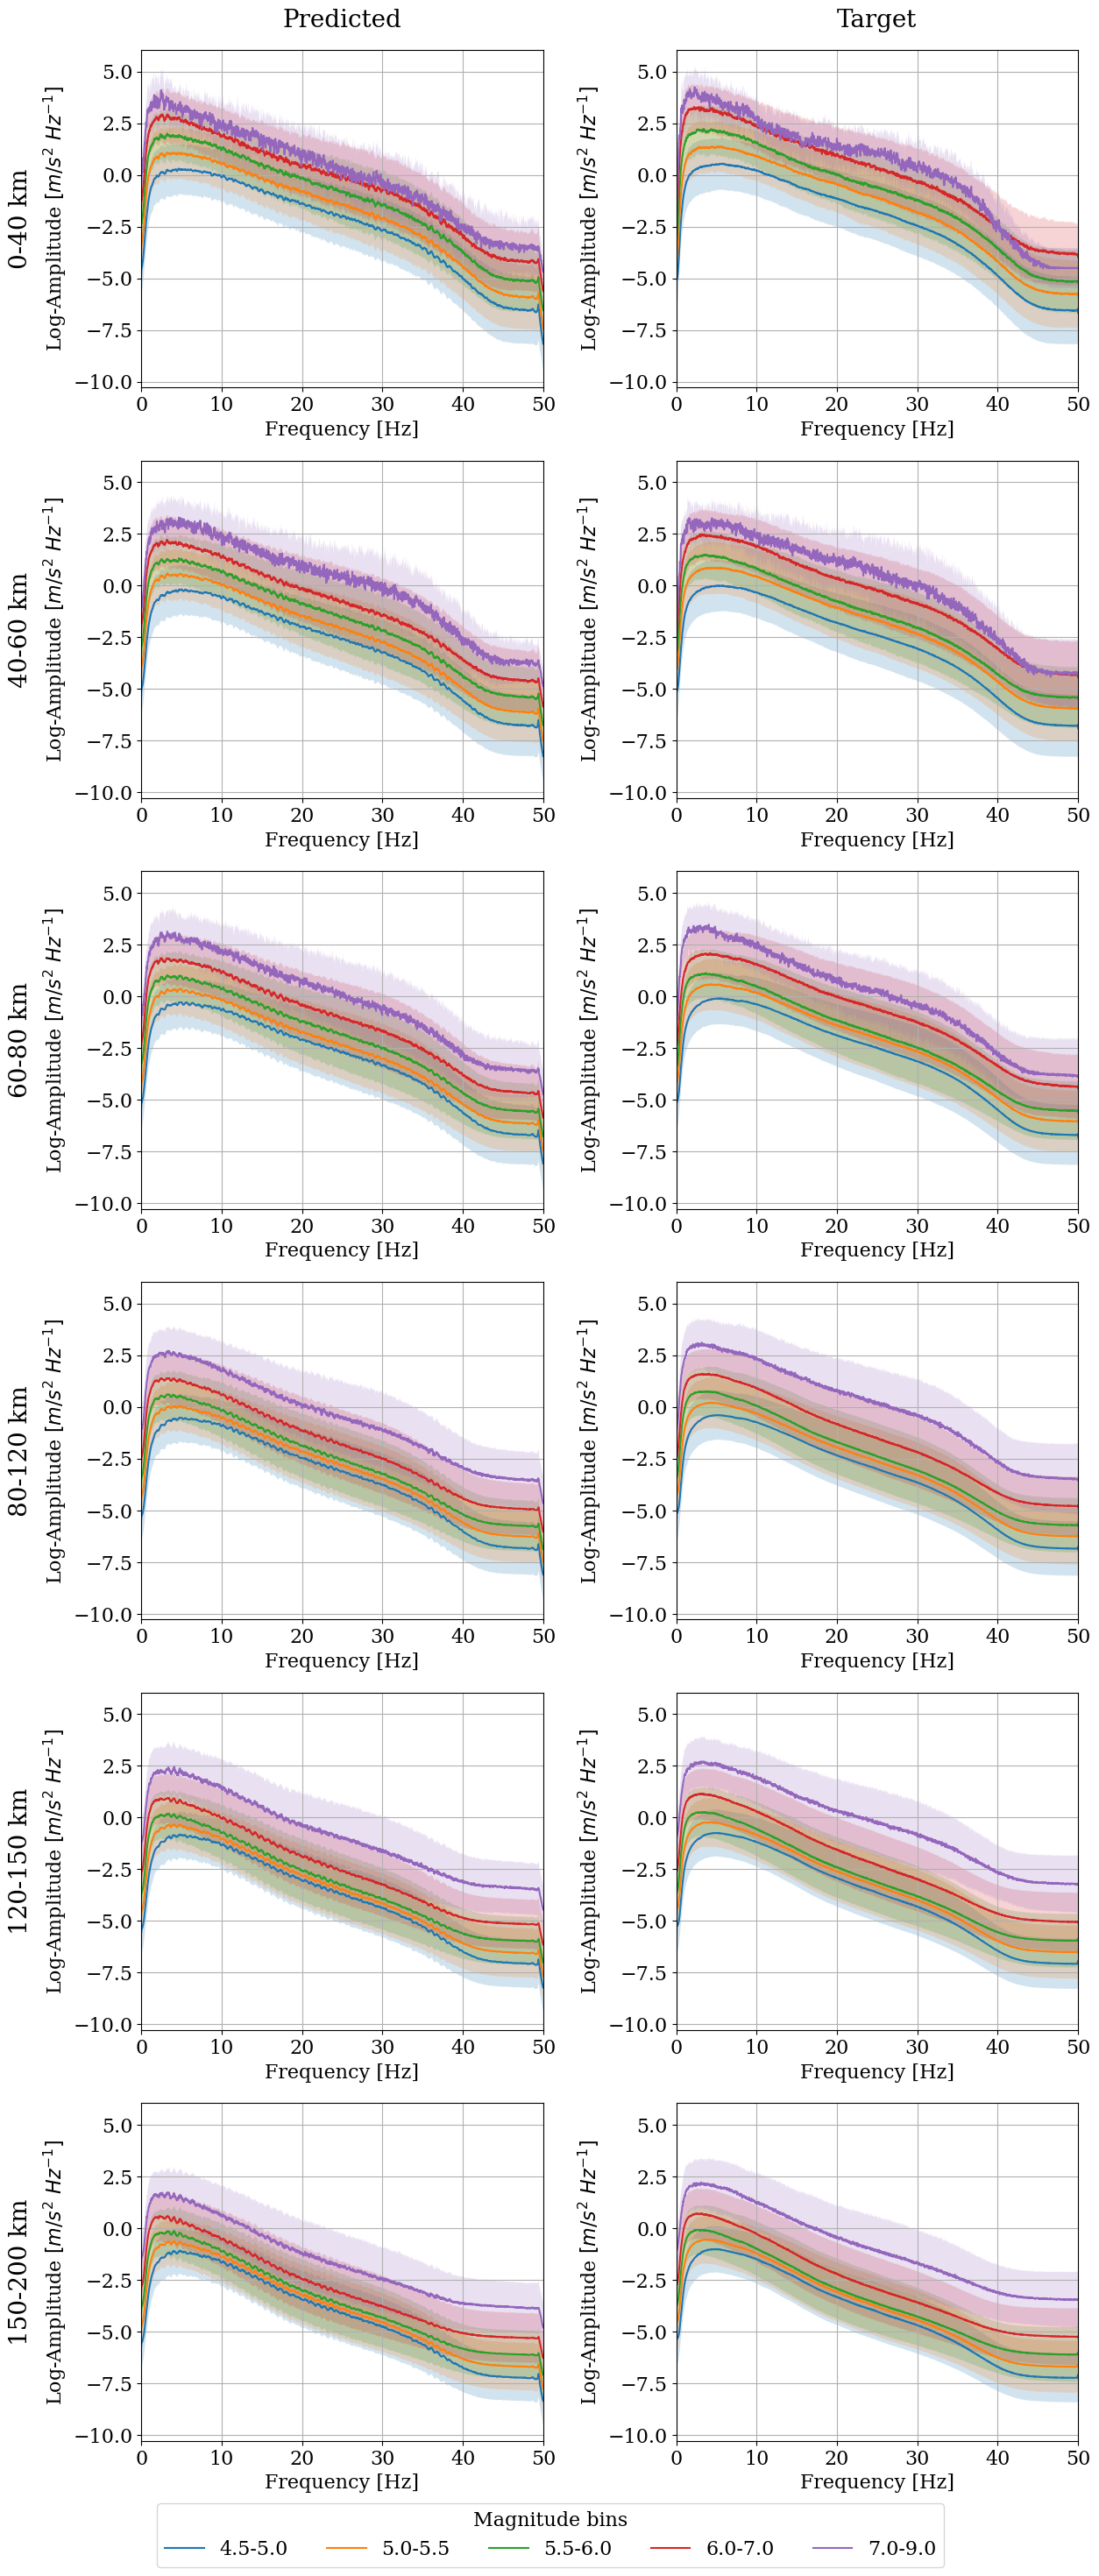

In [ ]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig(f"../figures/asd_grid_{channel}.pdf", bbox_inches="tight")

### Single distance bin

In [31]:
distance_bins = [0, 200]
magnitude_bins = [4.5, 5.0, 5.5, 6.0, 7.0, 9.0]

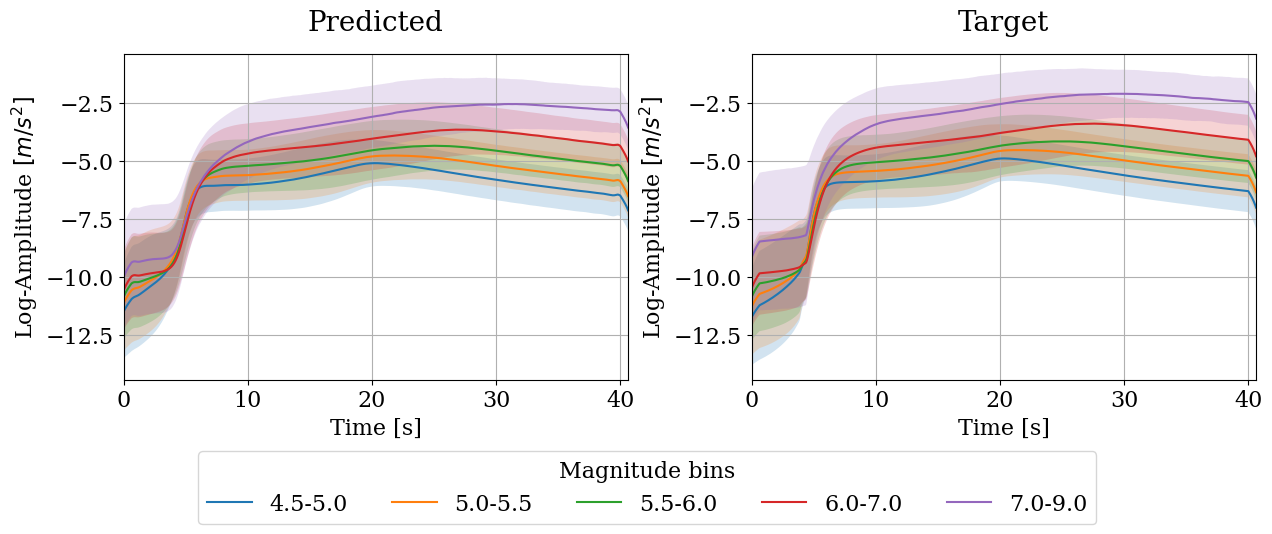

In [33]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/moving_average_envelope_small_grid.pdf", bbox_inches="tight")

In [ ]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_small_grid.pdf", bbox_inches="tight")

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/plot.py:230: RuntimeWarning: Mean of empty slice.
  mean = transformed.mean(axis=0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in div

KeyboardInterrupt: 

In [9]:
import h5py
import numpy as np

In [6]:
latent_edm1d_test = h5py.File("workdir/evaluation/Latent-EDM-MovingAvg-1024x16-split_test-rank_0.h5", "r")
edm1d_test = h5py.File("workdir/evaluation/EDM-MovingAvg-split_test-rank_0.h5", "r")
latent_edm_test = h5py.File("workdir/evaluation/Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4-split_test-rank_0.h5", "r")
edm_test = h5py.File("workdir/evaluation/EDM-128x128x4-LogSpectrogram-split_test-rank_0.h5", "r")

In [50]:
AmplitudeSpectralDensity(100, 0)(latent_edm1d_test["predicted_waveform"], latent_edm1d_test["target_waveform"])

np.float32(222.267)

In [55]:
print(f"Latent EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print(f"Latent EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print(f"Latent EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print()
print(f"Latent MovingAverage EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print(f"Latent MovingAverage EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print(f"Latent MovingAverage EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print()
print(f"MovingAverage EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")
print(f"MovingAverage EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")
print(f"MovingAverage EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")
print()
print(f" EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")
print(f" EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")
print(f" EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")


Latent EDM - Channel 0: Generated (Test) vs Test: 39.70000076293945
Latent EDM - Channel 1: Generated (Test) vs Test: 24.81999969482422
Latent EDM - Channel 2: Generated (Test) vs Test: 32.2400016784668

Latent MovingAverage EDM - Channel 0: Generated (Test) vs Test: 222.27000427246094
Latent MovingAverage EDM - Channel 1: Generated (Test) vs Test: 201.75999450683594
Latent MovingAverage EDM - Channel 2: Generated (Test) vs Test: 194.5399932861328

MovingAverage EDM - Channel 0: Generated (Test) vs Test: 2675.780029296875
MovingAverage EDM - Channel 1: Generated (Test) vs Test: 2579.6298828125
MovingAverage EDM - Channel 2: Generated (Test) vs Test: 2457.590087890625

 EDM - Channel 0: Generated (Test) vs Test: 195.69000244140625
 EDM - Channel 1: Generated (Test) vs Test: 73.23999786376953
 EDM - Channel 2: Generated (Test) vs Test: 202.74000549316406


In [17]:
print(f"Latent EDM - Generated (Test) classifier accuracy: {accuracy(latent_edm_test['predicted_classifier_pred'][:], get_label(latent_edm_test['magnitude'][:], latent_edm_test['hypocentral_distance'][:] * 1000))}")
print(f"EDM - Generated (Test) classifier accuracy: {accuracy(edm_test['predicted_classifier_pred'][:], get_label(edm_test['magnitude'][:], edm_test['hypocentral_distance'][:] * 1000))}")
print(f"Latent MovingAvg EDM - Generated (Test) classifier accuracy: {accuracy(latent_edm1d_test['predicted_classifier_pred'][:], get_label(latent_edm1d_test['magnitude'][:], latent_edm1d_test['hypocentral_distance'][:] * 1000))}")
print(f"MovingAvg EDM - Generated (Test) classifier accuracy: {accuracy(edm1d_test['predicted_classifier_pred'][:], get_label(edm1d_test['magnitude'][:], edm1d_test['hypocentral_distance'][:] * 1000))}")

Latent EDM - Generated (Test) classifier accuracy: 69.12912912912913
EDM - Generated (Test) classifier accuracy: 63.93393393393393
Latent MovingAvg EDM - Generated (Test) classifier accuracy: 45.92717717717718
MovingAvg EDM - Generated (Test) classifier accuracy: 8.397147147147146


In [20]:
print(f"Latent EDM - Generated (Test) classifier accuracy: {frechet_distance(latent_edm_test['predicted_classifier_embedding'][:], latent_edm_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"EDM - Generated (Test) classifier accuraacy: {frechet_distance(edm_test['predicted_classifier_embedding'][:], edm_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"Latent MovingAvg EDM - Generated (Test) classifier accuracy: {frechet_distance(latent_edm1d_test['predicted_classifier_embedding'][:], latent_edm1d_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"MovingAvg EDM - Generated (Test) classifier accuracy: {frechet_distance(edm1d_test['predicted_classifier_embedding'][:], edm1d_test['target_classifier_embedding'][:], isotropic=False)}")

Latent EDM - Generated (Test) classifier accuracy: 18.466005776572274
EDM - Generated (Test) classifier accuraacy: 99.2314652425448
Latent MovingAvg EDM - Generated (Test) classifier accuracy: 1142.3236297173862
MovingAvg EDM - Generated (Test) classifier accuracy: 5381.605256517098
